# Importando Bibliotecas

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#Plot
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Processamento
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools

Definindo uma seed padrão, para manter uma constância nos resultados, caso seja necessário rodar o projeto novamente

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)

Selecionando o dispositivo para rodar o projeto (Prefencialmente GPU)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Carregando e Processando os Dados

Iremos trabalhar com o valor de fechamento do BTC no dia, então iremos remover o valor de abertura do dataset

In [4]:
dataset = pd.read_csv('../data/Bitstamp_BTCUSD_d.csv')

In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

dataset

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1717459200,2024-06-04,BTC/USD,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,1717372800,2024-06-03,BTC/USD,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,1717286400,2024-06-02,BTC/USD,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,1717200000,2024-06-01,BTC/USD,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,1717113600,2024-05-31,BTC/USD,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


Podemos verificar que a coluna 'symbol' apenas um único valor para todas as instâncias, por isso vamor removê-la

In [6]:
dataset['symbol'].describe()

count        3477
unique          1
top       BTC/USD
freq         3477
Name: symbol, dtype: object

In [7]:
dataset.drop(['symbol'], axis=1, inplace=True)

Agora iremos configurar a coluna de data para ser o index do dataset. Além disso, iremos remover instâncias que possuem alguma coluna com valor NA ou que sejam duplicatas.

In [8]:
# Configura a coluna de data como index do Dataframe
dataset.set_index('date', inplace=True, drop=False)
dataset = dataset.reset_index(drop=True)

# Verificar e remover valores nulos
dataset = dataset.dropna()

# Verificar e remover duplicatas
dataset = dataset.drop_duplicates()

In [9]:
dataset

,unix,date,open,high,low,close,Volume BTC,Volume USD
0,1717459200,2024-06-04,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,1717372800,2024-06-03,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,1717286400,2024-06-02,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,1717200000,2024-06-01,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,1717113600,2024-05-31,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,1417392000,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,1417305600,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,1417219200,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


# Análise Exploratória

In [10]:
dataset

,unix,date,open,high,low,close,Volume BTC,Volume USD
0,1717459200,2024-06-04,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,1717372800,2024-06-03,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,1717286400,2024-06-02,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,1717200000,2024-06-01,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,1717113600,2024-05-31,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...,...,...
3472,1417478400,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,1417392000,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,1417305600,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,1417219200,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [11]:
num_linhas = int(len(dataset) * 0.2) # Pegando 20% do dataset

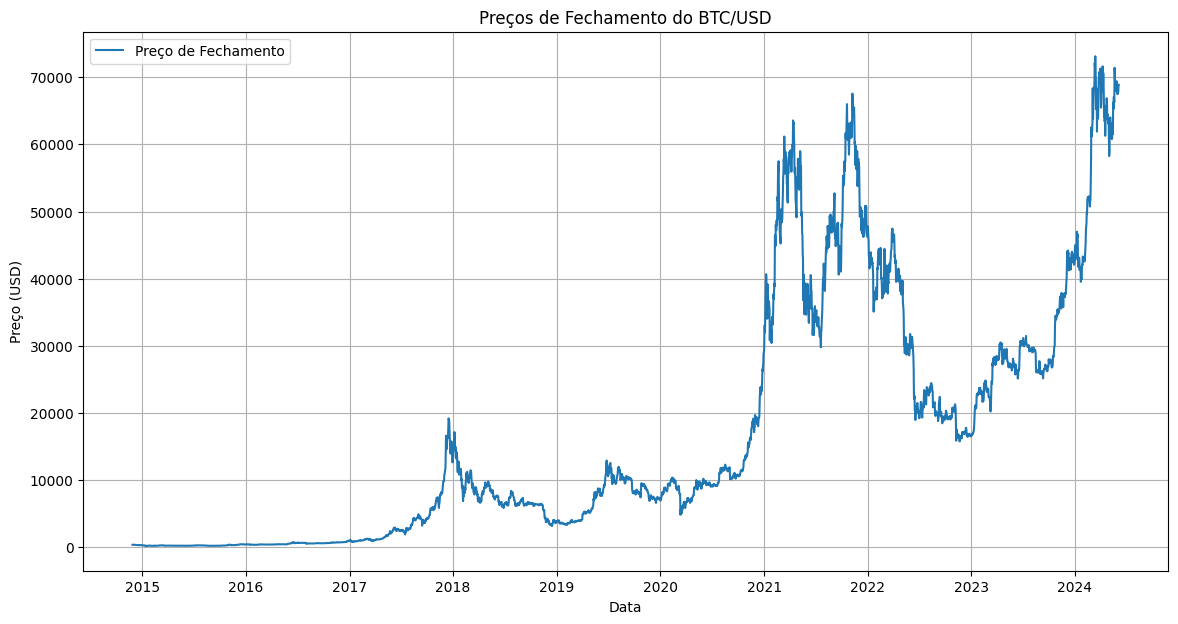

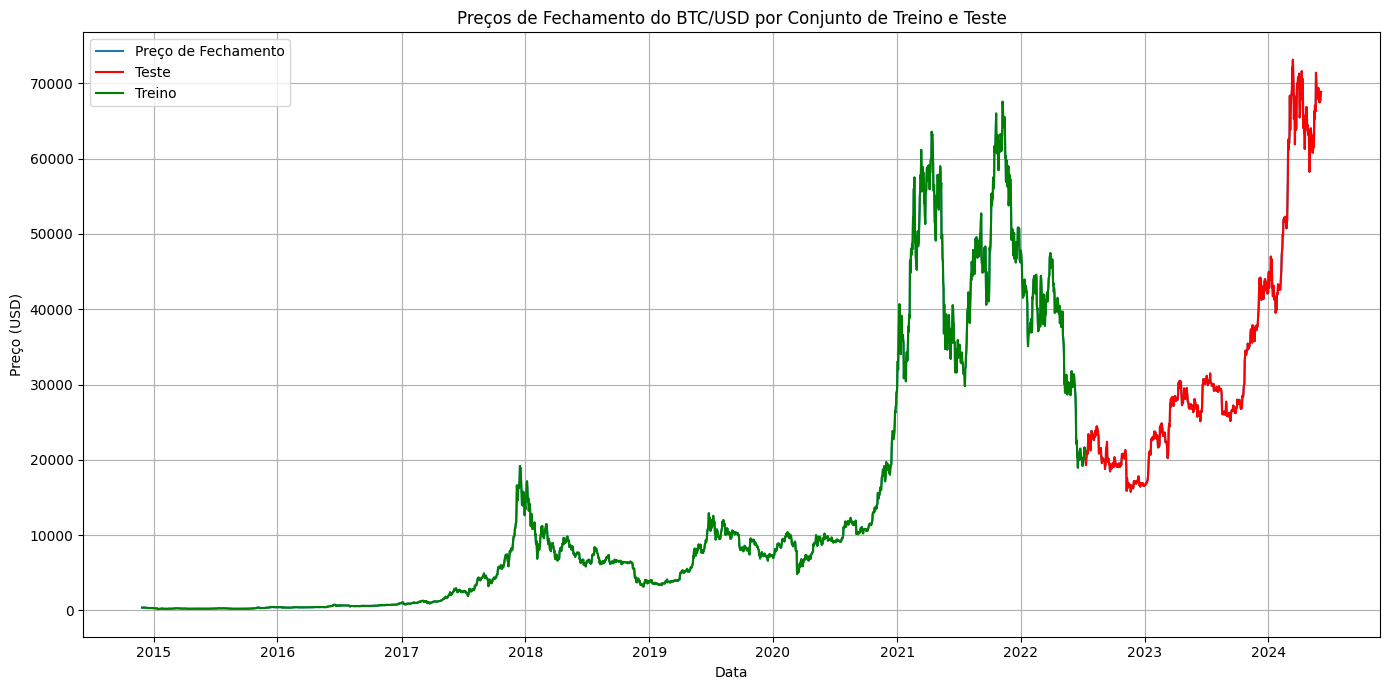

In [12]:
# Plotar os preços de fechamento ao longo do tempo
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.title('Preços de Fechamento do BTC/USD')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plotar os preços de fechamento do conjunto de treino e teste
plt.figure(figsize=(14, 7))
plt.plot(dataset['date'], dataset['close'], label='Preço de Fechamento')
plt.plot(dataset.iloc[:num_linhas]['date'], dataset.iloc[:num_linhas]['close'], label='Teste', color='red')
plt.plot(dataset.iloc[num_linhas:]['date'], dataset.iloc[num_linhas:]['close'], label='Treino', color='green')
plt.title('Preços de Fechamento do BTC/USD por Conjunto de Treino e Teste')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

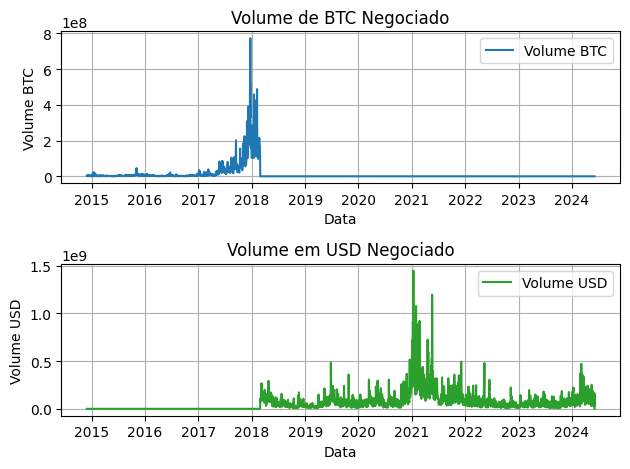

In [13]:
plt.subplot(2, 1, 1)
plt.plot(dataset['date'], dataset['Volume BTC'], label='Volume BTC', color='tab:blue')
plt.title('Volume de BTC Negociado')
plt.xlabel('Data')
plt.ylabel('Volume BTC')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(dataset['date'], dataset['Volume USD'], label='Volume USD', color='tab:green')
plt.title('Volume em USD Negociado')
plt.xlabel('Data')
plt.ylabel('Volume USD')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

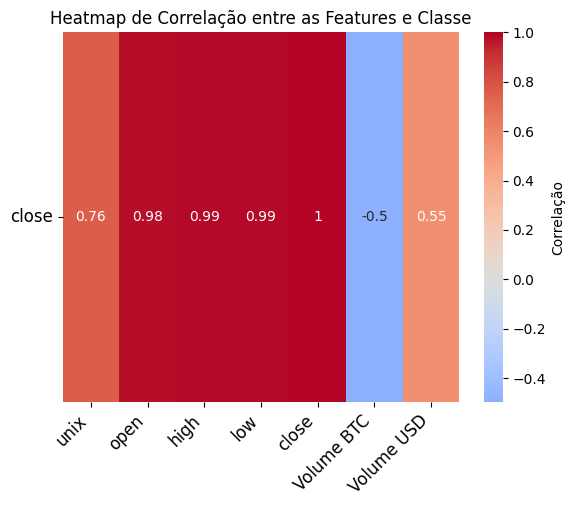

In [14]:
# Calcular a correlação entre preço e volume
correlation = dataset.corr(method='kendall', numeric_only=True)

sns.heatmap(correlation[['close']].T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlação'})
plt.title('Heatmap de Correlação entre as Features e Classe')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

# Divisão dos Dados

In [15]:
# ['date', 'unix', 'open', 'low', 'high', 'Volume USD', 'Volume BTC']
dp_dataset = dataset.drop(['date', 'unix'], axis=1)

# Normaliza os dados
scaler = MinMaxScaler(feature_range=(0, 1))
sc_dataset = scaler.fit_transform(dp_dataset)

In [16]:
dp_dataset

,open,high,low,close,Volume BTC,Volume USD
0,68798.00,68868.00,68792.00,68857.00,6.283420e-01,4.326574e+04
1,67744.00,70268.00,67590.00,68801.00,2.391376e+03,1.645291e+08
2,67722.00,68405.00,67281.00,67752.00,5.443606e+02,3.688152e+07
3,67513.00,67810.00,67387.00,67723.00,3.686240e+02,2.496433e+07
4,68330.00,69010.00,66624.00,67477.00,1.880059e+03,1.268607e+08
...,...,...,...,...,...,...
3472,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
3473,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
3474,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
3475,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [17]:
sc_dataset

array([[9.40631510e-01, 9.33053515e-01, 9.64207250e-01, 9.41556217e-01,
        8.13567301e-10, 2.99183890e-05],
       [9.26186822e-01, 9.52080125e-01, 9.47322286e-01, 9.40788662e-01,
        3.09631584e-06, 1.13772323e-01],
       [9.25885320e-01, 9.26761144e-01, 9.42981643e-01, 9.26410724e-01,
        7.04829553e-07, 2.55036798e-02],
       ...,
       [2.94060410e-03, 2.29882214e-03, 3.10334946e-03, 2.89669540e-03,
        1.48326158e-03, 2.10654612e-06],
       [2.93854840e-03, 2.36147405e-03, 3.08831875e-03, 2.94302279e-03,
        3.55568085e-03, 5.01007010e-06],
       [2.76271790e-03, 2.28998836e-03, 2.92424523e-03, 2.93699201e-03,
        4.17034228e-03, 5.95878446e-06]])

In [18]:
sc_dataset.shape

(3477, 6)

In [19]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage * len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point * (1 - validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val = y_data[split_train_validation_starting_point:split_training_test_starting_point]
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [20]:
# n_future -> Number of days you want to predict into the future
# n_past -> Number of past days you want to use to predict the future
X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    sc_dataset, n_future=1, n_past=7, train_test_split_percentage=0.75, validation_split_percentage=0
)

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2602, 7, 6)
y_train shape: (2602, 1)
X_val shape: (0,)
y_val shape: (0,)
X_test shape: (868, 7, 6)
y_test shape: (868, 1)


# Treinando o Modelo LSTM

In [22]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=15, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=15, return_sequences=False))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

c:\Users\Felipe Moraes\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 15)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 15)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,196 (12.48 KB)

 Trainable params: 3,196 (12.48 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=13)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=75, batch_size=16, callbacks=[es])

Epoch 1/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0689 - root_mean_squared_error: 0.2535 - val_loss: 9.7993e-04 - val_root_mean_squared_error: 0.0312
Epoch 2/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114 - root_mean_squared_error: 0.1065 - val_loss: 7.9567e-04 - val_root_mean_squared_error: 0.0282
Epoch 3/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 7.3814e-04 - val_root_mean_squared_error: 0.0272
Epoch 4/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 7.8015e-04 - val_root_mean_squared_error: 0.0279
Epoch 5/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 8.2053e-04 - val_root_mean_squared_error: 0.0287
Epoch 6/75
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055 - root_mean_squared_error: 0.0737 - val_loss: 8.8755e-04 - val_root_mean_squared_error: 0.0298
Epoch 7/75
114/114 ━━━━━━━━

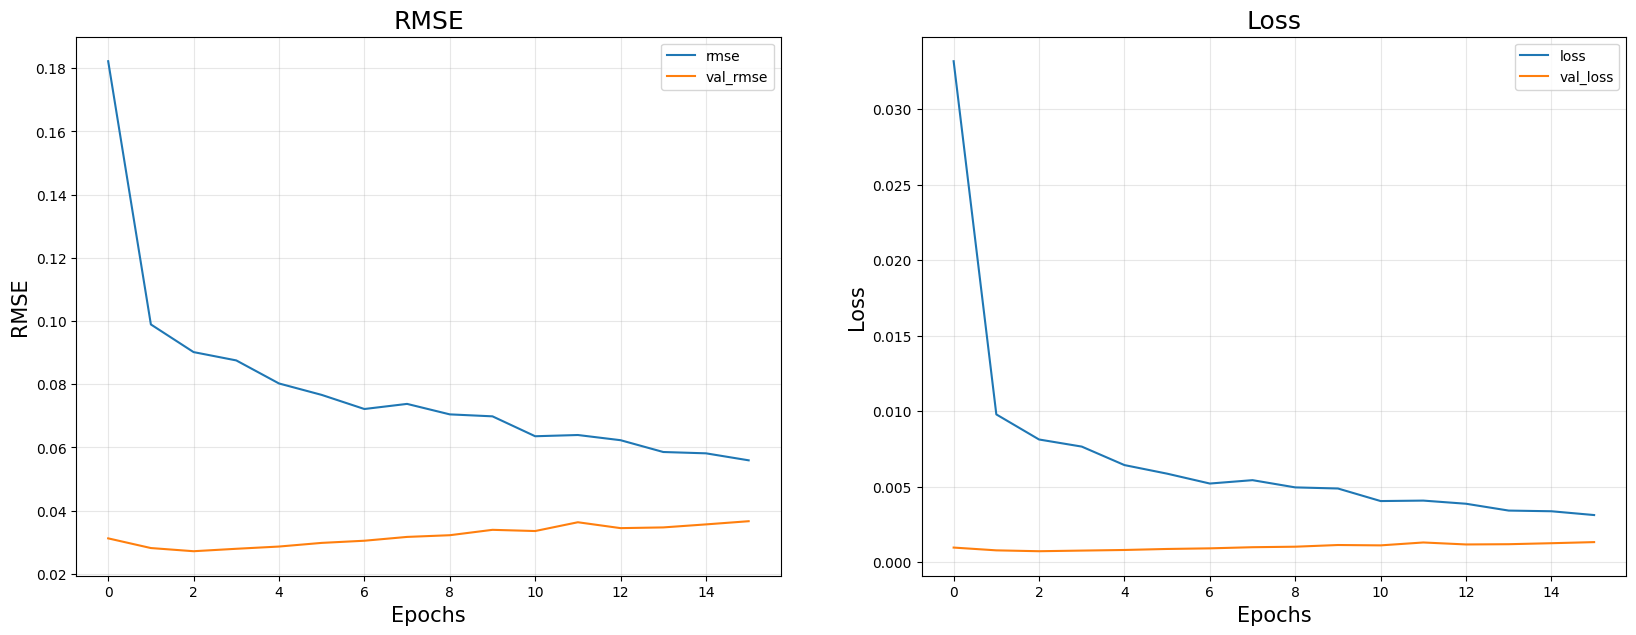

In [24]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

# Tunning

In [29]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = f'../models/model_{i}.keras'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [30]:
config = [
    [False, True],
    [False, True],
    [False, True],
    [16, 32],
    [8, 16, 32],
    [0.2]
]  

# list of lists --> [
#   [first_additional_layer],
#   [second_additional_layer],
#   [third_additional_layer],
#   [n_neurons],
#   [n_batch_size],
#   [dropout]
# ]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2), (False, False, True, 16, 8, 0.2), (False, False, True, 16, 16, 0.2), (False, False, True, 16, 32, 0.2), (False, False, True, 32, 8, 0.2), (False, False, True, 32, 16, 0.2), (False, False, True, 32, 32, 0.2), (False, True, False, 16, 8, 0.2), (False, True, False, 16, 16, 0.2), (False, True, False, 16, 32, 0.2), (False, True, False, 32, 8, 0.2), (False, True, False, 32, 16, 0.2), (False, True, False, 32, 32, 0.2), (False, True, True, 16, 8, 0.2), (False, True, True, 16, 16, 0.2), (False, True, True, 16, 32, 0.2), (False, True, True, 32, 8, 0.2), (False, True, True, 32, 16, 0.2), (False, True, True, 32, 32, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 16, 32, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 

In [33]:
# Verificando o melhor modelo treinado
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist.head()

,0,1,2,3,4,5,6,7
45,True,True,True,32,8,0.2,"[0.0011776855681091547, 0.034460097551345825]","[1.4853880202281289e-05, 0.003858175128698349]"
16,False,True,False,32,16,0.2,"[0.0007144050905480981, 0.026836484670639038]","[3.838188058580272e-05, 0.00618852348998189]"
5,False,False,False,32,32,0.2,"[0.0007931820582598448, 0.02827753871679306]","[4.175602589384653e-05, 0.006449233274906874]"
3,False,False,False,32,8,0.2,"[0.0006952866679057479, 0.026471974328160286]","[4.848332537221722e-05, 0.00696083577349782]"
29,True,False,False,32,32,0.2,"[0.0014390115393325686, 0.0380910187959671]","[4.89342310174834e-05, 0.006979858037084341]"


In [34]:
# load the best model
regressor = load_model('model_45.keras')

# Testando o modelo

In [27]:
regressor = load_model('best_model.keras')

In [40]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 7))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1927e-05 - root_mean_squared_error: 0.0065
test loss, test acc: [4.6100e-05 6.7862e-03]


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


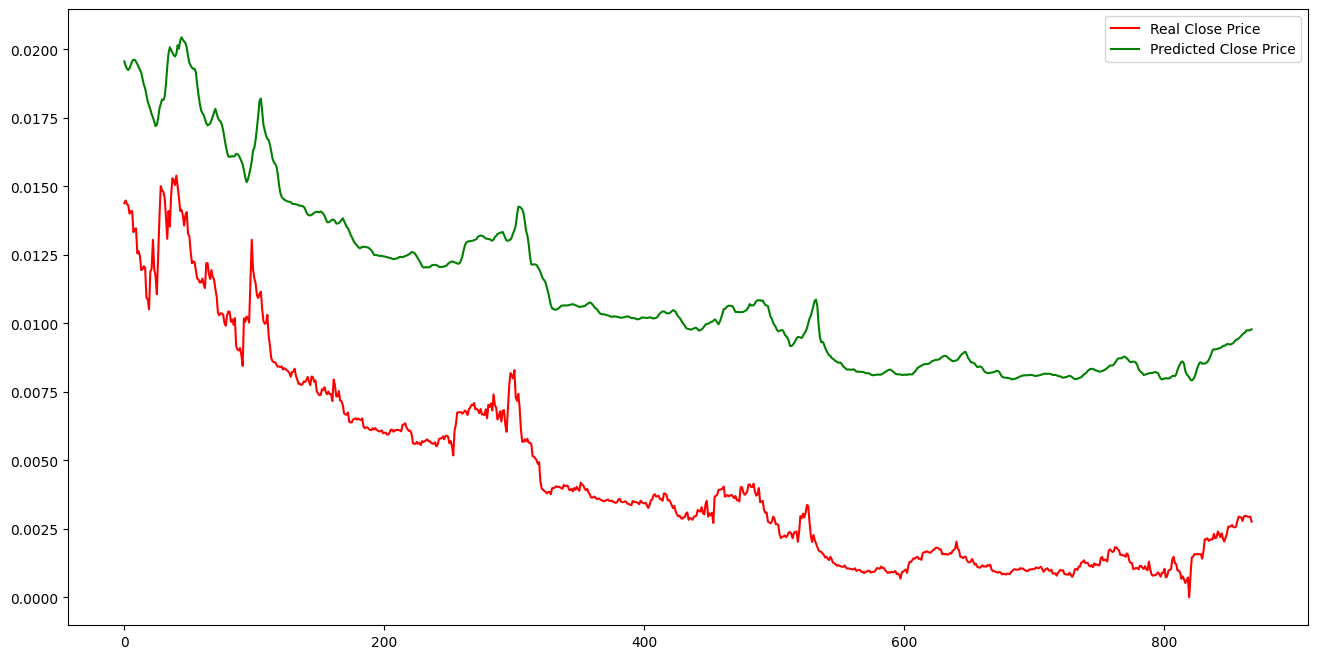

In [42]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Close Price')
plt.plot(y_pred, color='green', label = 'Predicted Close Price')
plt.legend(loc='best')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


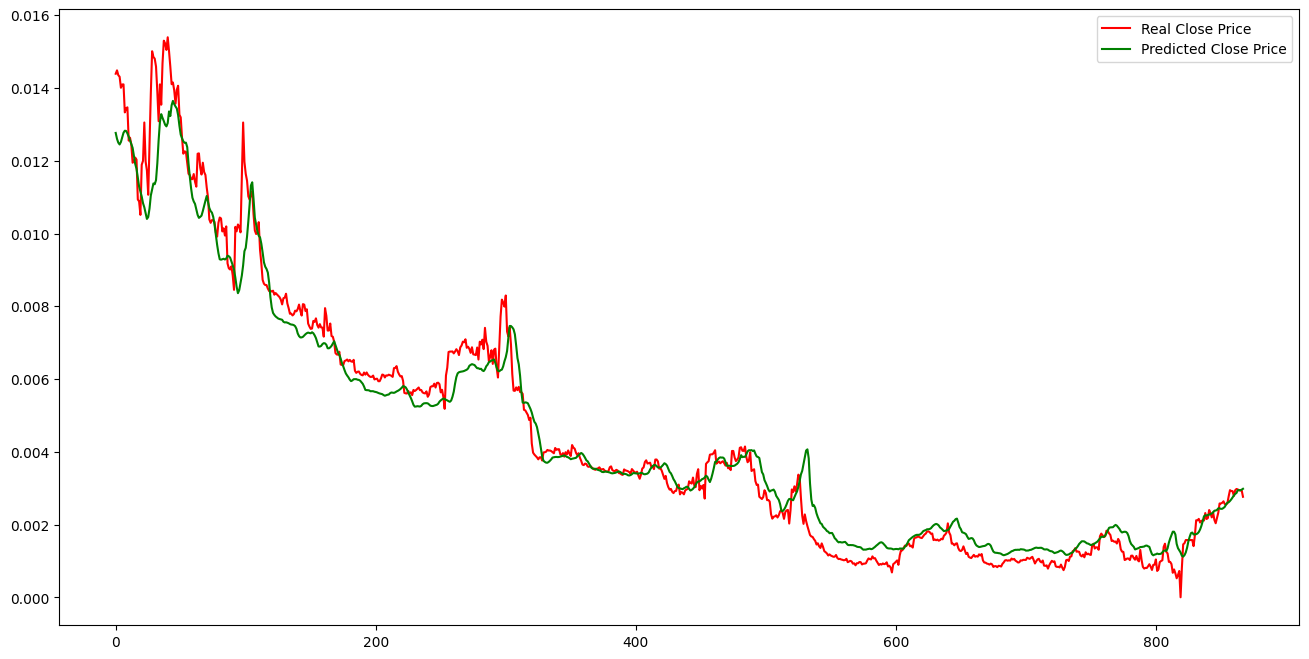

In [69]:
idx = 233
aux_err = np.round(y_pred[idx][0] - y_test[idx][0], 4)

y_pred = regressor.predict(X_test)
y_pred = y_pred - 0.0068
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Close Price')
plt.plot(y_pred, color='green', label = 'Predicted Close Price')
plt.legend(loc='best')